# Gaussian Process Regression for Time Forecast 

Reference [Docs](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)

## Prepare Notebook
 

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## Example 1

### Generate Data

- Time Variable
 
Let us define a "time" variable $t\in \mathbb{N}$. 

In [31]:
# Number of samples. 
n = 700
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

- Seasonal Component

Let us define a function to generate seasonal components (Fourier modes).  

In [32]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    
    return(y1)

# Add two seasonal components. 
data_df ['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df ['y1'] = data_df ['s1']

Let us plot this seasonal variable:

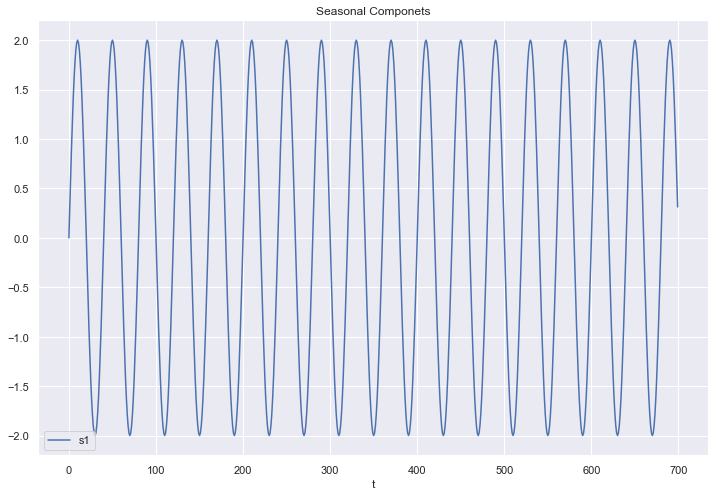

In [33]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
sns.lineplot(x='t', y='s1', data=data_df, label='s1', ax=ax) 
ax.set(title='Seasonal Componets', xlabel='t', ylabel='')
ax.legend(loc='lower left');

- Gaussian Noise 

In [34]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

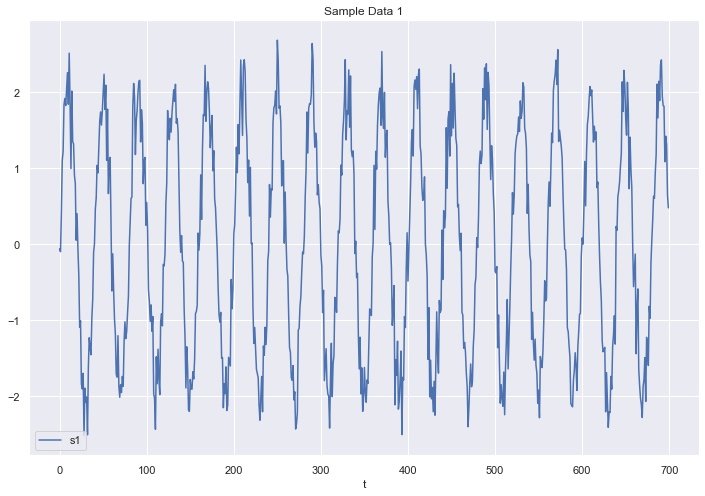

In [35]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, label='s1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

### Define Model

In [36]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor
 
# Define GaussianProcessRegressor object. 
gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

In [38]:
X = data_df['t'].values.reshape(n ,1)
y = data_df['y1'].values.reshape(n ,1)

n_train = round(0.7*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

### Model Fit + Predictions

In [39]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [40]:
y_pred_train = gp1.predict(X_train) 
y_pred_test = gp1.predict(X_test) 

y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

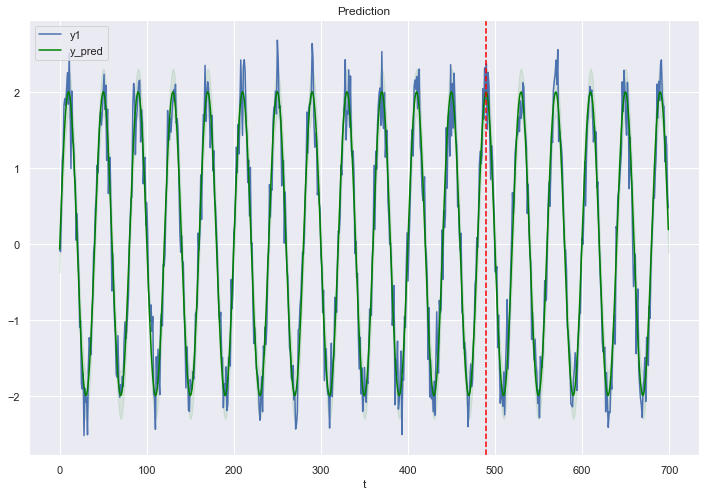

In [41]:
fig, ax = plt.subplots()

sns.lineplot(x='t', y='y1', data=data_df, label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3**2
)

ax.axvline(n_train, color='red', linestyle='--')
ax.set(title='Prediction', xlabel='t', ylabel='')
ax.legend(loc='upper left');

## Example 2

- Trend Component

Next we generate a non-linear trend component:

In [42]:
# Generate trend component. 
def linear_trend(beta, t):
    
    trend_comp = beta * t #(np.power(t, 1/2))
    
    return(trend_comp)

data_df ['y3'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

Let us see the trend plot:

In [43]:
# Add trend to target variable. 
data_df ['y2'] = data_df ['y1'] + data_df ['y3']

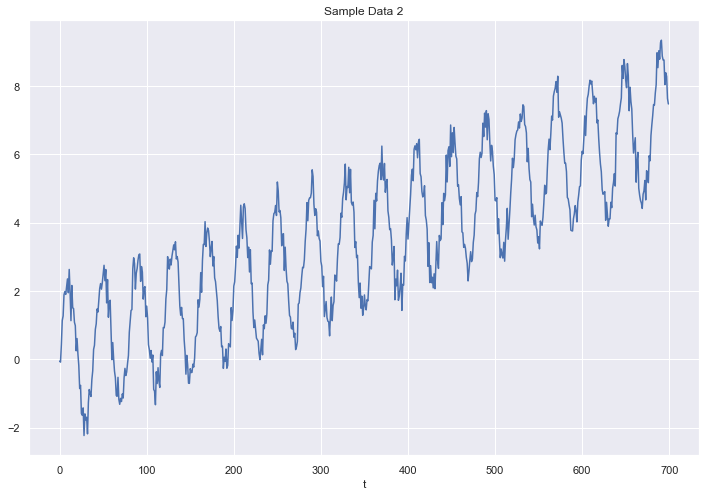

In [44]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y2', data=data_df, ax=ax)
ax.set(title='Sample Data 2', xlabel='t', ylabel='');

### Define Model

In [45]:
from sklearn.gaussian_process.kernels import RBF

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)) 

kernel_2  = k0 + k1 + k2

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
 
# Define GaussianProcessRegressor object. 
gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

In [47]:
X = data_df['t'].values.reshape(n ,1)
y = data_df['y2'].values.reshape(n ,1)

n_train = round(0.7*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

### Model Fit + Predictions

In [48]:
gp2.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [49]:
y_pred_train = gp2.predict(X_train) 
y_pred_test = gp2.predict(X_test) 

y_pred, y_std = gp2.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

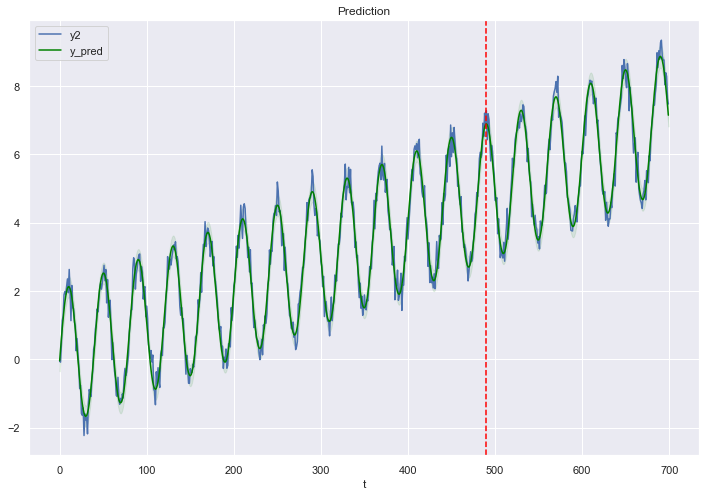

In [50]:
fig, ax = plt.subplots()

sns.lineplot(x='t', y='y2', data=data_df, label = 'y2', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3**2
)

ax.axvline(n_train, color='red', linestyle='--')
ax.set(title='Prediction', xlabel='t', ylabel='')
ax.legend(loc='upper left');

## Example 3

- Add Other Seasonal Component

Let us see the trend plot:

In [51]:
# Add two seasonal components. 
data_df ['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))

data_df ['y3'] = data_df ['y2'] + data_df ['s2'] 

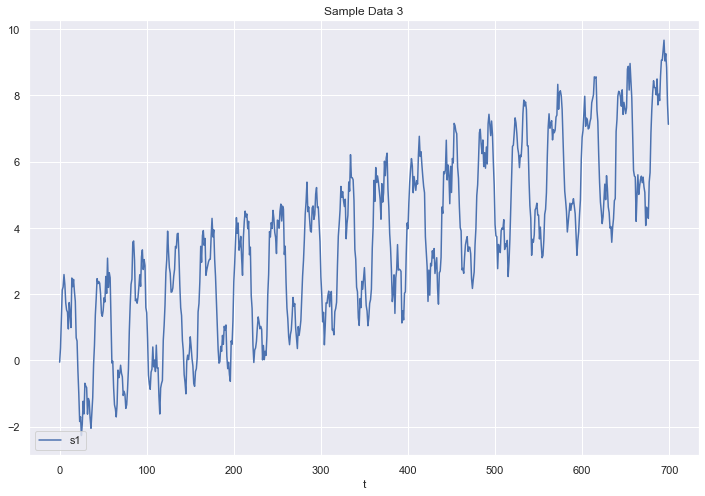

In [52]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y3', data=data_df, label='s1', ax=ax) 
ax.set(title='Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='lower left');

### Define Model

In [53]:
from sklearn.gaussian_process.kernels import RBF

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)) 

k3 = ConstantKernel(constant_value=1) * ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_3  = k0 + k1 + k2 + k3

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
 
# Define GaussianProcessRegressor object. 
gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

In [55]:
X = data_df['t'].values.reshape(n ,1)
y = data_df['y3'].values.reshape(n ,1)

n_train = round(0.7*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

### Model Fit + Predictions

In [56]:
gp3.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [57]:
y_pred_train = gp3.predict(X_train) 
y_pred_test = gp3.predict(X_test) 

y_pred, y_std = gp3.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

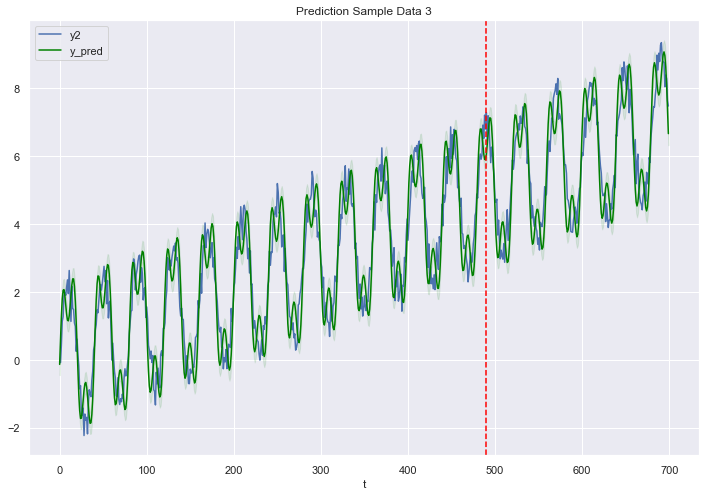

In [58]:
fig, ax = plt.subplots()

sns.lineplot(x='t', y='y2', data=data_df, label = 'y2', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3**2
)

ax.axvline(n_train, color='red', linestyle='--')
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='upper left');